In [1]:
# !pip install corner
# !pip install emcee

In [2]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def gaussian(x, mu, sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * \
           np.exp(-(x - mu)**2 / (2 * sigma**2))

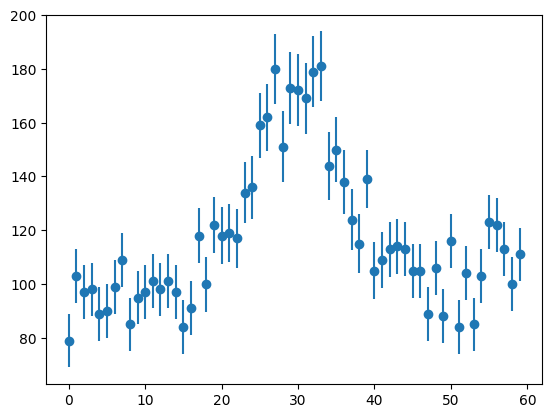

In [47]:
def model(x, params):
    mu, sigma, flux, background = params
    y = flux * gaussian(x, mu, sigma) + background
    return y

def generate_data(params):
    num_pixels = 60
    x = np.arange(0, num_pixels)
    y = model(x, params)
    sigma_err_list = np.sqrt(y)   # if flux is [counts] assuming poisson noise
    # add readout noise
    sigma_readout = 0
    s2 = sigma_err_list**2 + sigma_readout**2
    sigma_err_list = np.sqrt(s2)
    # for low signals
    y_data = np.random.poisson(y) + np.random.normal(0, sigma_readout, num_pixels)
    return x, y_data, sigma_err_list

MU_TRUE = 30
SIGMA_TRUE = 5  # well sampled   FWHM = 3 = 2.35 sigma
FLUX_TRUE = 1000   # [counts] not [counts / s]
BACKGROUND_TRUE = 100
PARAMS_TRUE = [MU_TRUE, SIGMA_TRUE, FLUX_TRUE, BACKGROUND_TRUE]

x_list, y_data_list, sigma_list = \
    generate_data(PARAMS_TRUE)

plt.errorbar(x_list, y_data_list, yerr=sigma_list, fmt='o');

In [51]:
def log_prior(pars):
    mu, sigma, flux, background = pars
    if 0 < mu < 60 and 0 < sigma and 0 < flux and 0 < background:
        return 0
    return -np.inf

In [65]:
def log_prob(pars, x_list, y_data_list, sigma_list):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    y_model_list = model(x_list, pars)
    log_likelihood = 0
    for y_data, y_model, sigma in zip(y_data_list, y_model_list, sigma_list):
        likelihood = gaussian(y_data, y_model, sigma)
        log_likelihood += np.log(likelihood)
    return lp + log_likelihood

pars_initial = np.array([30, 5, 1000, 100])

ndim = len(pars_initial)
nwalkers = 2 * ndim

start_pos = pars_initial + np.random.normal(0, 1e-5, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[x_list, y_data_list, sigma_list])
res = sampler.run_mcmc(start_pos, 3000)

In [66]:
samples = sampler.get_chain(flat=True)
samples.shape

(24000, 4)

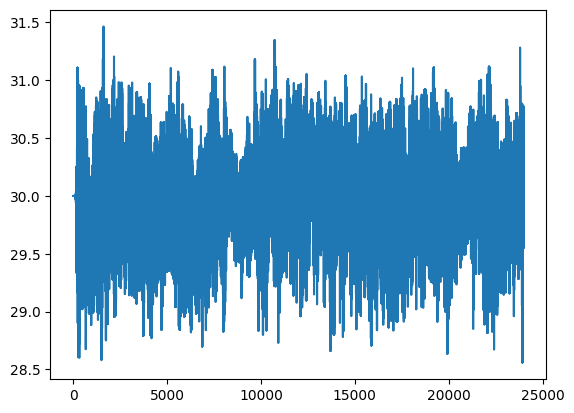

In [67]:
plt.plot(samples[:, 0]);

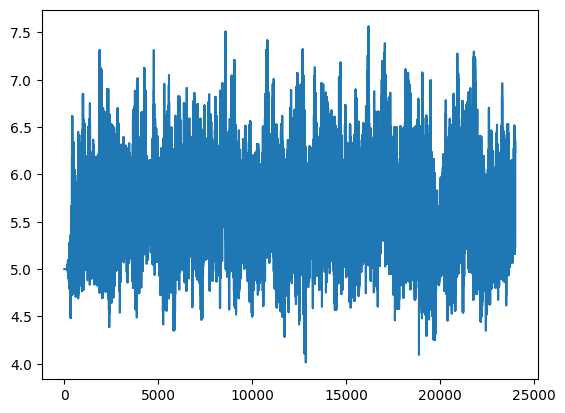

In [68]:
plt.plot(samples[:, 1]);

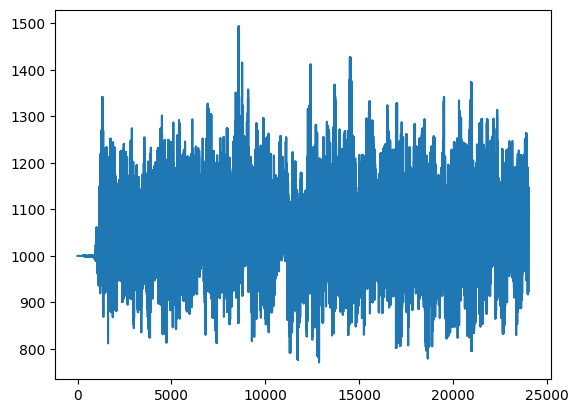

In [69]:
plt.plot(samples[:, 2]);

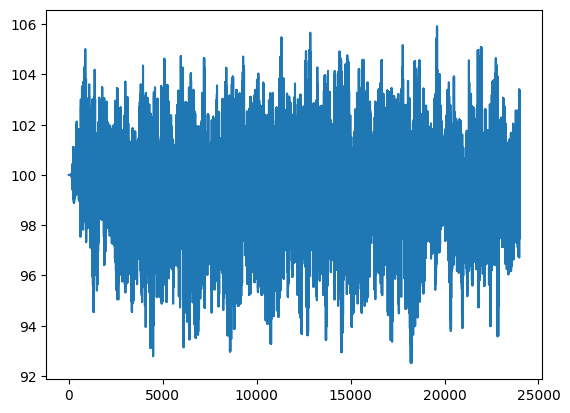

In [70]:
plt.plot(samples[:, 3]);

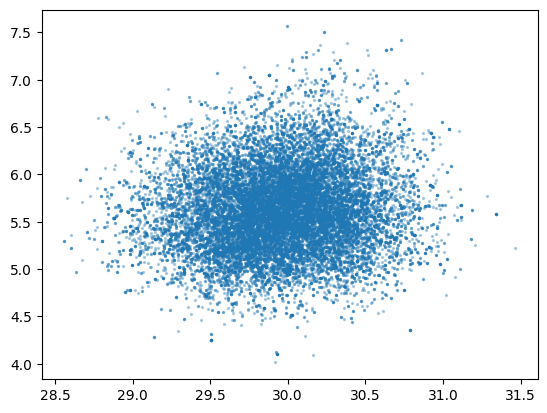

In [71]:
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.3);

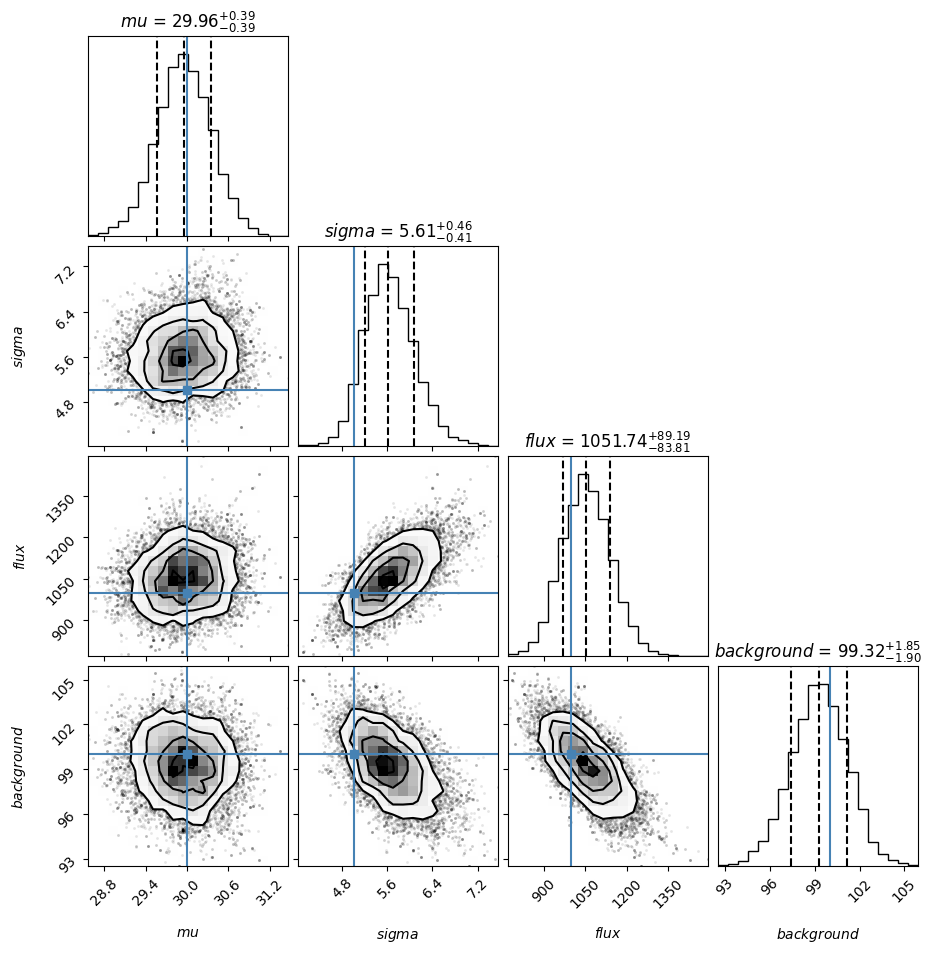

In [72]:
figure = corner.corner(
    samples[1000:],
    labels=[
        r"$mu$",
        r"$sigma$",
        r"$flux$",
        r"$background$",
    ],
    truths=PARAMS_TRUE,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [13]:
# 20    - 0.075
# 200   - 0.02

# np.sqrt(200/20) * 0.02

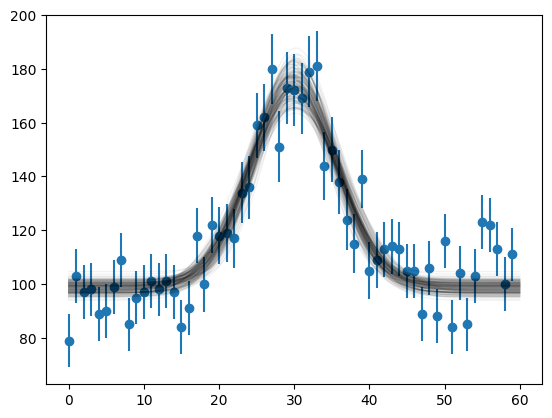

In [73]:
x_list_model = np.linspace(0, 60, 1000)
for mu, sigma, flux, background in samples[1000:17000:100]:
    y_model = model(x_list_model, [mu, sigma, flux, background])
    plt.plot(x_list_model, y_model, c='k', alpha=0.05, lw=1, zorder=2)
plt.errorbar(x_list, y_data_list, yerr=sigma_list, fmt='o', zorder=1);